In [1]:
%load_ext autoreload
%autoreload 2

import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import tensor
import tqdm
from typing import Any

import block_formats.experiments as E

matplotlib.rcParams.update({"axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False})

In [2]:
runs = E.runs('20250430-refresh')
len(runs)

2088

## Some Llama-3.1-8B runs OOM on 46 GB device

Persistent memory usage should be 2 bytes/param weights, plus 2 bytes/param Fisher -> 32 GB.

The failures include every example using `Q.LUTFormat`.

In [ ]:
import collections

def sorted_counts(d: list[Any]) -> None:
    counts = dict(collections.Counter(d))
    return {k: counts[k] for k in sorted(counts, key=lambda k: (counts[k], k), reverse=True)}

candidates = [run for run in runs
              if run.config.model == 'meta-llama/Llama-3.1-8B'
              and run.config.test.error_weight == "fisher"
              and run.config.test.fmt.element_family in ["t", "lloyd_max", "laplace", "normal"]]

print("Succeeded:", sorted_counts(run.config.test.fmt.element_family for run in candidates))
print("   Failed:", sorted_counts(run.config.test.fmt.element_family for run in candidates if run.error))

Succeeded: {'t': 108, 'lloyd_max': 72, 'normal': 36, 'laplace': 36}
   Failed: {'t': 86, 'lloyd_max': 72, 'laplace': 34, 'normal': 33}


In [31]:
display(sorted_counts(run.error.message for run in candidates if run.error))
display(sorted_counts([run.error.cause.trace[-1] for run in candidates if run.error]))

{"Failed to quantise 'model.embed_tokens.weight'": 225}

{'  File "/home/ubuntu/SquashedLlama/notebooks/20250127-FormatsCascade/block_formats/quantisation.py", line 329, in to_idx\n    return torch.bucketize(x, boundaries)\n           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n': 153,
 '  File "/home/ubuntu/SquashedLlama/notebooks/20250127-FormatsCascade/block_formats/quantisation.py", line 599, in lut_lloyd_max\n    idx = torch.randperm(tensor.nelement(), device=tensor.device, dtype=torch.int32)\n          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n': 72}

## Analysis

In [39]:
def pareto_optimal(df: pd.DataFrame) -> pd.Series:
    kl_div = np.array(df.kl_div)
    bits_per_param = np.array(df.bits_per_param)
    optimal = (
        ~((kl_div[None, :] < kl_div[:, None]) & (bits_per_param[None, :] <= bits_per_param[:, None])).any(1)
        & ~((kl_div[None, :] <= kl_div[:, None]) & (bits_per_param[None, :] < bits_per_param[:, None])).any(1)
    )
    return pd.Series(optimal, index=df.index)

def get_element_format_name(fmt: E.AttrDict) -> str:
    name = fmt.element_family
    if name == "fp" and "exponent_bits" in fmt.args:
        name = f"{name}-E{fmt.args.exponent_bits:.0f}"
    if name == "t" and "df" in fmt.args:
        name = f"{name}[{fmt.args.df:.0f}]"
    if fmt.compressor is not None:
        name = f"{name}+Z{fmt.compressor}"
    return name

weight_stats = {run.config.model: run.summary.weight_stats for run in E.runs("20250423-weight-stats")}
fisher_sum = {run.config.model: run.summary.fisher for run in E.runs("20250423-fisher")}

def to_row(run: dict[str, Any]) -> dict[str, Any]:
    test = run.config.test
    if run.meta.status == "finished":
        fmt = test.fmt
        wstats = weight_stats[run.config.model]
        fisher = fisher_sum[run.config.model]
        sse, fisher_sse = 0, 0
        for k, q in run.summary.params.items():
            sse += (q["rmse"] ** 2) * math.prod(wstats[k].shape)
            fisher_sse += (q["rmse"] ** 2) * fisher[k]
        return dict(
            model=run.config.model.split("/")[1],
            element_bits=fmt.element_bits,
            element_name=get_element_format_name(fmt),
            element_mode=fmt.args.get("mode", None),
            scaling=fmt.scaling,
            block={(None, None): "tensor", (1, None): "channel"}.get(tuple(fmt.block_shape), fmt.block_shape[1]),
            sparse_ratio=fmt.sparse_ratio,
            compression=fmt.compressor == "optimal",
            error_weight=test.error_weight or "none",
            kl_div=tensor(run.summary.kl_div).mean().item(),
            bits_per_param=run.summary["bits_per_param"],
            bit_allocation=run.config.test.type.replace("quantise_", ""),
            sse=sse,
            fisher_sse=fisher_sse,
        )

df = pd.DataFrame.from_records(list(filter(None, map(to_row, tqdm.tqdm(runs)))))
df.head().drop(columns=["bit_allocation"])

100%|██████████| 2088/2088 [00:00<00:00, 10558.07it/s]


,model,element_bits,element_name,element_mode,scaling,block,sparse_ratio,compression,error_weight,kl_div,bits_per_param,sse,fisher_sse
0,Llama-3.2-1B,3.0,int,None,absmax,tensor,0.000000,False,none,10.795511,3.033803,173448.338545,5.933003
1,Llama-3.2-1B,3.0,int,None,absmax,tensor,0.007812,False,none,0.711755,3.408783,22654.911396,0.651582
2,Llama-3.2-1B,3.0,int,None,absmax,tensor,0.000977,False,none,1.180674,3.080676,28520.211315,0.835254
3,Llama-3.2-1B,3.0,int,None,absmax,channel,0.000000,False,none,1.709952,3.040341,29339.723413,0.925538
4,Llama-3.2-1B,3.0,int,None,absmax,channel,0.007812,False,none,0.659639,3.415321,21805.037380,0.632984


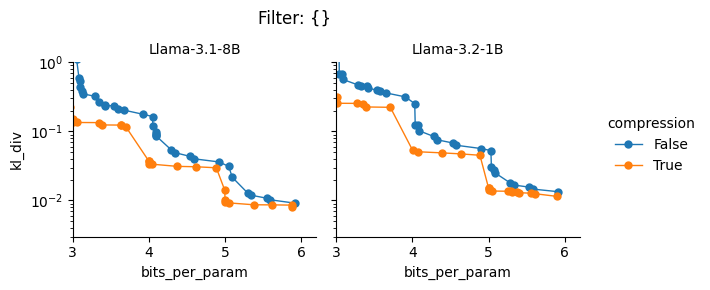

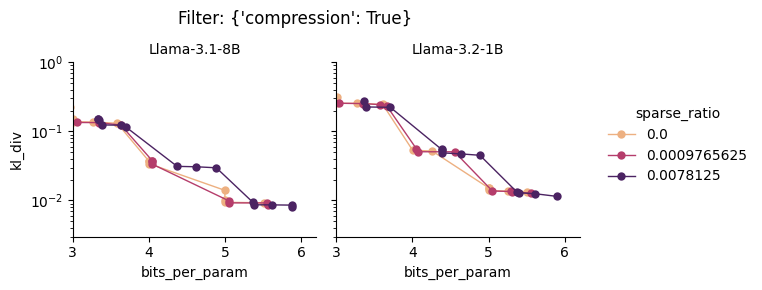

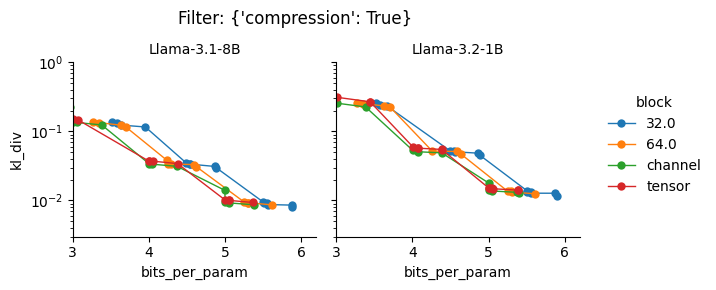

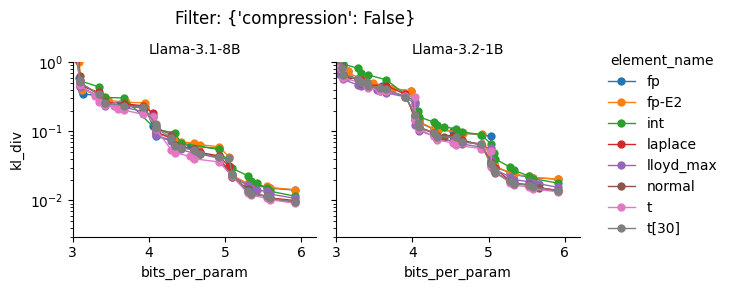

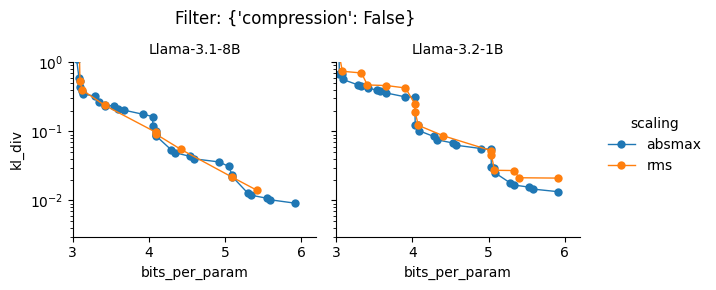

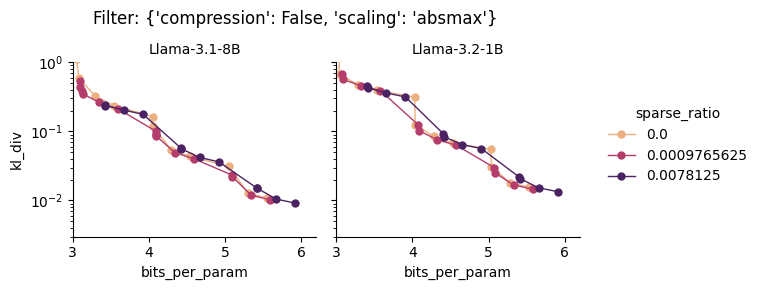

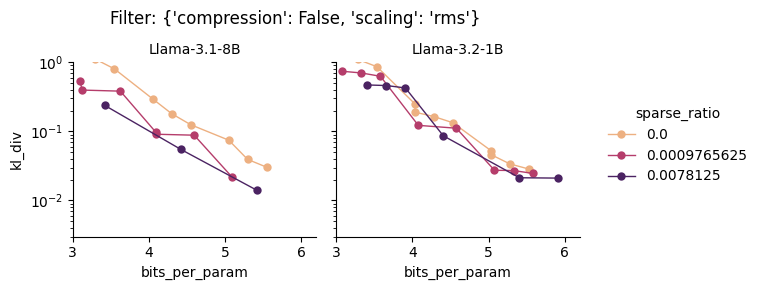

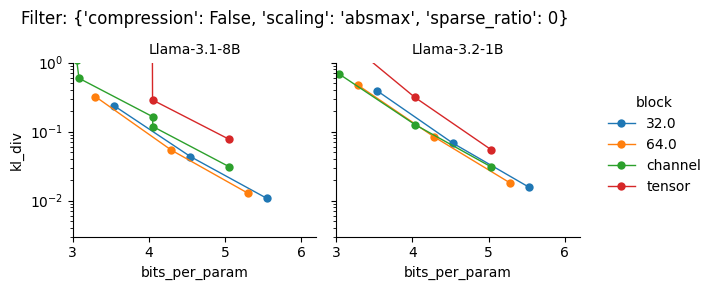

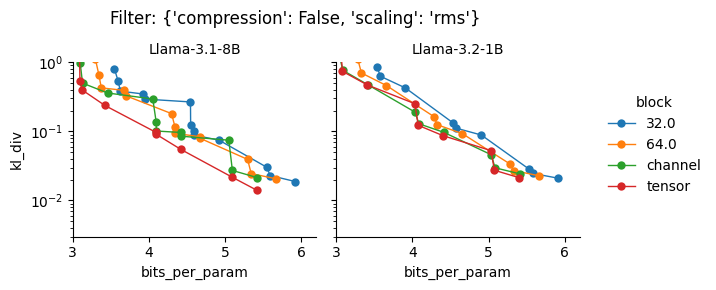

In [37]:
def filter_df(df: pd.DataFrame, select: dict[str, Any]) -> pd.DataFrame:
    d = df
    for c, value in select.items():
        d = d[d[c] == value].drop(columns=c)
    return d

def show_pareto(df: pd.DataFrame, select: dict[str, Any], hue: str, hue_norm: matplotlib.colors.Normalize | None = None, col: str = "model") -> None:
    d = (filter_df(df, select).groupby(["model", hue])
        .apply(lambda d: d[pareto_optimal(d)].sort_values("bits_per_param"), include_groups=False)
        .reset_index())

    cols = sorted(df[col].unique())
    fig, axs = plt.subplots(ncols=len(cols), figsize=(3*len(cols), 3), sharey=True)
    for col_value, ax in zip(cols, axs):
        ax = sns.lineplot(data=d[d[col] == col_value], y="kl_div", x="bits_per_param",
                          hue=hue, hue_norm=hue_norm, palette="flare" if d[hue].dtype.kind == "f" else None,
                          marker="o", mew=0, lw=1, ax=ax)
        ax.set_yscale("log")
        ax.set_ylim((3e-3, 1))
        ax.set_xlim((3, 6.2))
        ax.set_title(col_value, fontsize=10)
        ax.legend_.remove()
    fig.legend(*axs[0].get_legend_handles_labels(), loc="center left", bbox_to_anchor=(1, 0.5), title=hue)
    fig.suptitle(f"Filter: {str(select)}", y=0.95)
    fig.tight_layout()

show_pareto(df, {}, hue="compression")
show_pareto(df, dict(compression=True), hue="sparse_ratio", hue_norm=matplotlib.colors.SymLogNorm(2**-10))
show_pareto(df, dict(compression=True), hue="block")

show_pareto(df, dict(compression=False), hue="element_name")
show_pareto(df, dict(compression=False), hue="scaling")
show_pareto(df, dict(compression=False, scaling="absmax"), hue="sparse_ratio", hue_norm=matplotlib.colors.SymLogNorm(2**-10))
show_pareto(df, dict(compression=False, scaling="rms"), hue="sparse_ratio", hue_norm=matplotlib.colors.SymLogNorm(2**-10))
show_pareto(df, dict(compression=False, scaling="absmax", sparse_ratio=0), hue="block")
show_pareto(df, dict(compression=False, scaling="rms"), hue="block")

## Fix variable bit allocation

In [40]:
runs_fix_variable = E.runs("20250502-fix-variable-width")
df = pd.DataFrame.from_records(list(filter(None, map(to_row, tqdm.tqdm(runs_fix_variable)))))
df.head()

100%|██████████| 360/360 [00:00<00:00, 8508.10it/s]


,model,element_bits,element_name,element_mode,scaling,block,sparse_ratio,compression,error_weight,kl_div,bits_per_param,bit_allocation,sse,fisher_sse
0,Llama-3.2-1B,3.0,int+Zoptimal,None,absmax,tensor,0.0,True,none,0.520004,3.008618,fixed,11160.656280,0.732324
1,Llama-3.2-1B,3.0,int+Zoptimal,None,absmax,tensor,0.0,True,none,0.300000,3.011935,variable,13253.167111,0.375732
2,Llama-3.2-1B,3.0,int+Zoptimal,None,absmax,tensor,0.0,True,none,0.229036,3.817760,heuristic,6534.124239,0.271789
3,Llama-3.2-1B,3.5,int+Zoptimal,None,absmax,tensor,0.0,True,none,0.222463,3.501200,fixed,5598.759719,0.368351
4,Llama-3.2-1B,3.5,int+Zoptimal,None,absmax,tensor,0.0,True,none,0.128737,3.506774,variable,6706.492539,0.186671


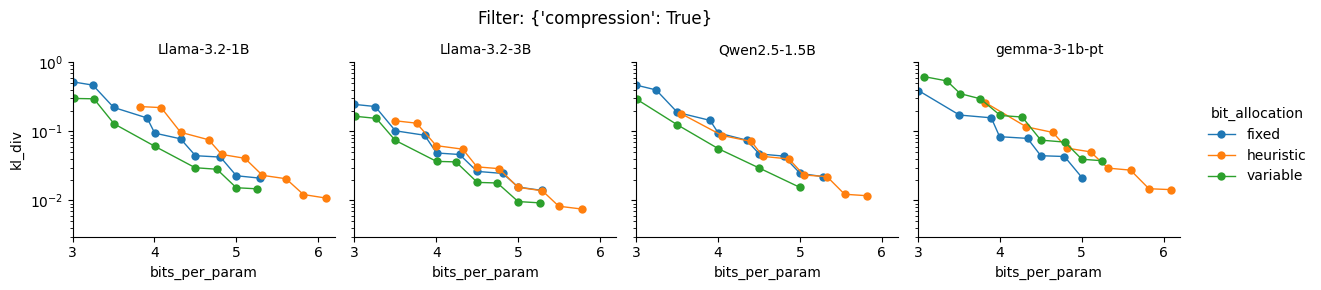

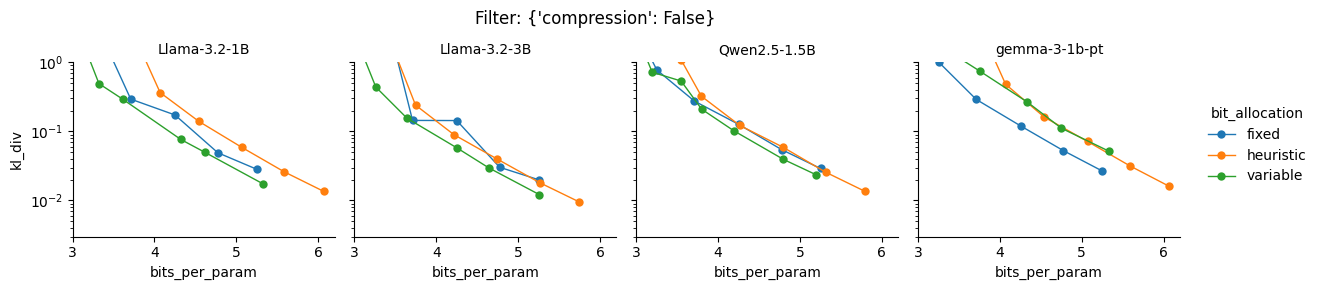

In [44]:
show_pareto(df, dict(compression=True), "bit_allocation")
show_pareto(df, dict(compression=False), "bit_allocation")

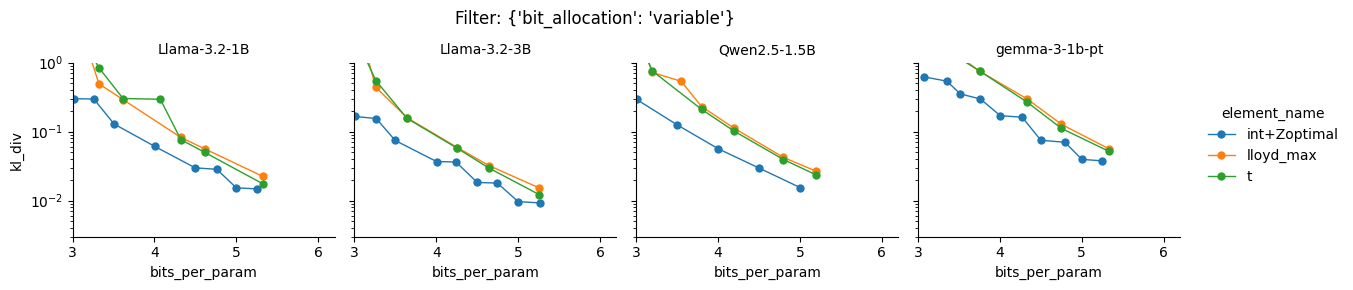

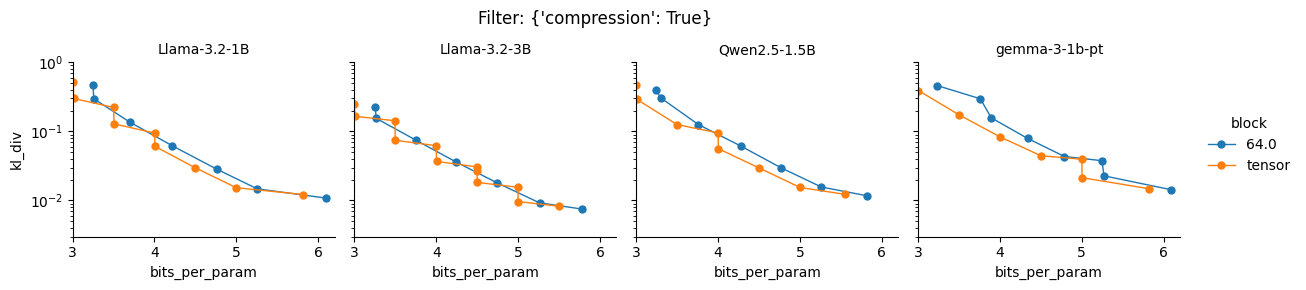

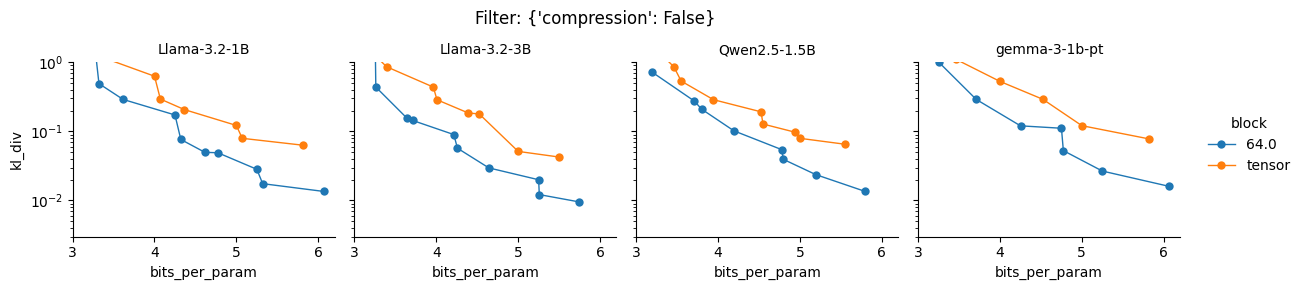

In [46]:
show_pareto(df, dict(bit_allocation="variable"), "element_name")
show_pareto(df, dict(compression=True), "block")
show_pareto(df, dict(compression=False), "block")